In [8]:
import pandas as pd

# Chemin complet vers le fichier CSV à charger (à adapter selon l'emplacement du fichier)
file_path = r"C:\Users\liamb\Desktop\ESG\poids_et_prix_par_date.csv"

try:
    # Lecture du fichier CSV avec conversion automatique de la colonne 'Date' en objet datetime
    df = pd.read_csv(file_path, parse_dates=['Date'])

    # On utilise la colonne 'Date' comme index du DataFrame pour faciliter les opérations temporelles
    df.set_index('Date', inplace=True)

    # Affiche un aperçu rapide des 5 premières lignes pour s'assurer que le chargement s'est bien passé
    print("Aperçu du DataFrame :")
    print(df.head())

    # Affiche des informations utiles sur le DataFrame : nb de colonnes, types de données, valeurs manquantes, etc.
    print("\nStructure du DataFrame :")
    print(df.info())

# Gestion des erreurs courantes pour éviter que le script plante brutalement

except FileNotFoundError:
    # Cas où le fichier n'existe pas au chemin spécifié
    print(f"Erreur : Fichier {file_path} introuvable.")
except pd.errors.EmptyDataError:
    # Cas où le fichier est vide (aucune donnée à lire)
    print("Erreur : Fichier vide.")
except Exception as e:
    # Pour toute autre erreur inattendue (ex: problème de permissions, mauvaise structure du fichier, etc.)
    print(f"Erreur : {e}")


Aperçu du DataFrame :
            CICN_weight  CICN_price  OPUS_weight  OPUS_price  SECO_weight  \
Date                                                                        
2022-02-07     0.000000        0.01          0.0      0.0001          0.0   
2022-03-07     0.038421        0.01          0.0      0.0001          0.0   
2022-04-04     0.000000        0.01          0.0      0.0001          0.0   
2022-05-02     0.000000        0.01          0.0      0.0001          0.0   
2022-06-06     0.000000        0.01          0.0      0.0001          0.0   

            SECO_price  SGER_weight  SGER_price  LEON_weight  LEON_price  ...  \
Date                                                                      ...   
2022-02-07       3.703          0.0      0.0300          0.0      0.0800  ...   
2022-03-07       3.624          0.0      0.0001          0.0      0.0100  ...   
2022-04-04       3.876          0.0      0.0001          0.0      0.0101  ...   
2022-05-02       3.250          0

Nombre de tickers détectés : 1575


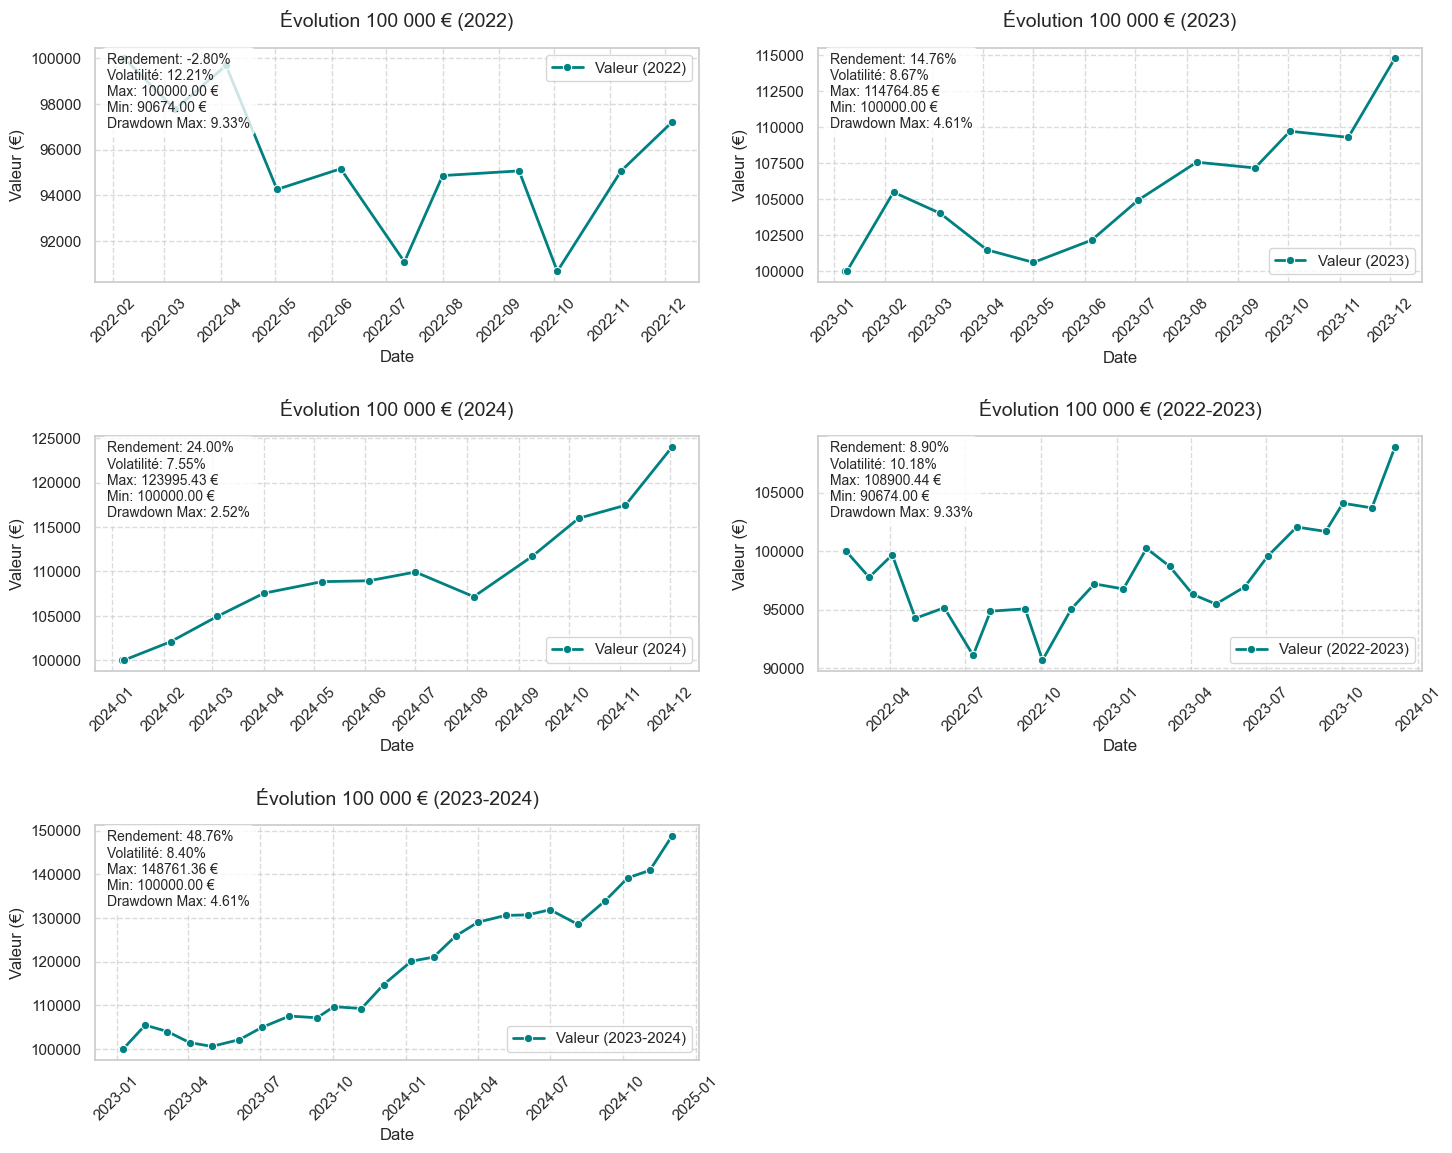

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Appliquer un style plus esthétique
# On utilise seaborn pour rendre les graphiques plus jolis avec un fond en grille et une palette de couleurs atténuées
sns.set(style="whitegrid", palette="muted")
# On ajuste la taille des figures et la taille de la police pour une meilleure lisibilité
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Supposons que 'df' est déjà chargé avec 1500 tickers
# On part du principe que le DataFrame 'df' contient déjà les données, avec un index basé sur des dates
# et des colonnes au format TICKER_weight (poids) et TICKER_price (prix) pour chaque ticker

# Identifier dynamiquement tous les tickers
# On extrait les noms des tickers en prenant la partie avant '_' dans les colonnes qui se terminent par '_weight'
# Cela nous permet de gérer dynamiquement les 1500 tickers sans les lister manuellement
tickers = [col.split('_')[0] for col in df.columns if col.endswith('_weight')]
# On affiche le nombre de tickers détectés pour vérifier que tout est bien chargé
print(f"Nombre de tickers détectés : {len(tickers)}")

# Paramètres
# On définit l'investissement initial en euros, ici fixé à 100 000 €
initial_investment = 100000  # 100 000 €

# Définir les périodes
# On crée une liste de tuples contenant les périodes à tester pour le backtesting
# Chaque tuple contient un nom (ex. '2022') et les dates de début et de fin au format datetime
periods = [
    ('2022', '2022-02-07 00:00:00', '2022-12-31 23:59:59'),  # Période 2022 complète
    ('2023', '2023-01-01 00:00:00', '2023-12-31 23:59:59'),  # Période 2023 complète
    ('2024', '2024-01-01 00:00:00', '2024-12-02 00:00:00'),  # Période 2024 complète (jusqu'au 2 déc)
    ('2022-2023', '2022-02-07 00:00:00', '2023-12-31 23:59:59'),  # Période combinée 2022-2023
    ('2023-2024', '2023-01-01 00:00:00', '2024-12-02 00:00:00')  # Période combinée 2023-2024
]

# Fonction de simulation
def simulate_portfolio(start_date, end_date):
    # On filtre le DataFrame pour ne garder que les données dans la période spécifiée
    mask = (df.index >= start_date) & (df.index <= end_date)
    df_period = df.loc[mask]
    # On initialise un dictionnaire pour chaque ticker avec quantité et valeur initiales à 0
    portfolio = {ticker: {'quantity': 0, 'value': 0} for ticker in tickers}
    # On initialise la trésorerie avec l'investissement initial
    cash = initial_investment
    # Liste pour stocker les valeurs du portefeuille à chaque date
    portfolio_value = []
    # On récupère les dates de la période filtrée
    dates = df_period.index

    for date in dates:
        # On calcule la somme des poids non nuls pour normaliser l'allocation
        total_weight = sum(df_period[f'{ticker}_weight'][date] for ticker in tickers if df_period[f'{ticker}_weight'][date] > 0)
        if total_weight > 0:
            for ticker in tickers:
                # On récupère le poids et le prix pour chaque ticker à la date courante
                weight = df_period[f'{ticker}_weight'][date]
                price = df_period[f'{ticker}_price'][date]
                if weight > 0 and price > 0:
                    # Si le poids est positif, on calcule la somme disponible proportionnelle au poids
                    available_cash = cash * (weight / total_weight)
                    # On calcule la quantité d'actifs à acheter avec cette somme
                    quantity = available_cash / price
                    # On met à jour la quantité et la valeur dans le portefeuille
                    portfolio[ticker]['quantity'] += quantity
                    portfolio[ticker]['value'] = portfolio[ticker]['quantity'] * price
                    # On soustrait la somme investie de la trésorerie
                    cash -= available_cash
                elif weight == 0 and portfolio[ticker]['quantity'] > 0:
                    # Si le poids devient 0 et qu'on détient des actifs, on vend tout
                    cash += portfolio[ticker]['quantity'] * price
                    portfolio[ticker]['quantity'] = 0
                    portfolio[ticker]['value'] = 0
        
        # On calcule la valeur totale du portefeuille (trésorerie + valeur des actifs)
        current_value = cash + sum(portfolio[ticker]['value'] for ticker in tickers)
        # On ajoute cette valeur à la liste
        portfolio_value.append(current_value)

    return dates, portfolio_value

# Calcul des métriques
def calculate_metrics(portfolio_value, dates):
    # On ajoute la valeur initiale avec une date fictive (1 jour avant la première date)
    # Cela permet de montrer le point de départ du portefeuille
    first_date = dates[0]
    plot_dates = [first_date - pd.Timedelta(days=1)] + list(dates)
    plot_values = [initial_investment] + list(portfolio_value)

    # On crée une série pandas pour analyser les valeurs
    portfolio_series = pd.Series(plot_values, index=plot_dates)
    # On calcule les rendements en pourcentage entre chaque période
    returns = portfolio_series.pct_change().dropna()

    # Rendement total
    # On calcule le rendement total en pourcentage par rapport à l'investissement initial
    final_value = portfolio_value[-1]
    total_return = (final_value - initial_investment) / initial_investment * 100

    # Volatilité annualisée (sur base mensuelle, facteur √12)
    # On annualise la volatilité en utilisant l'écart-type des rendements multiplié par √12
    volatility = returns.std() * np.sqrt(12) * 100

    # Valeurs max et min
    # On trouve les valeurs maximale et minimale du portefeuille sur la période
    max_value = max(portfolio_series)
    min_value = min(portfolio_series)

    # Drawdown maximum
    # On calcule le drawdown en comparant la valeur courante au maximum cumulé
    running_max = np.maximum.accumulate(portfolio_series)
    drawdowns = (running_max - portfolio_series) / running_max * 100
    max_drawdown = drawdowns.max()

    return total_return, volatility, max_value, min_value, max_drawdown, plot_dates, plot_values

# Générer les graphiques et métriques pour chaque période
# On crée une figure pour regrouper tous les graphiques
fig = plt.figure(figsize=(15, 12))

for i, (period, start_date, end_date) in enumerate(periods, 1):
    # On simule le portefeuille pour chaque période
    dates, portfolio_value = simulate_portfolio(start_date, end_date)
    # On calcule les métriques pour cette période
    total_return, volatility, max_value, min_value, max_drawdown, plot_dates, plot_values = calculate_metrics(portfolio_value, dates)

    # Graphique
    # On crée un sous-graphique pour chaque période dans une grille 3x2
    ax = plt.subplot(3, 2, i)
    # On trace la courbe avec seaborn pour un rendu amélioré
    sns.lineplot(x=plot_dates, y=plot_values, label=f'Valeur ({period})', marker='o', linewidth=2, color='teal')
    # On ajoute un titre clair et des étiquettes pour les axes
    plt.title(f'Évolution 100 000 € ({period})', fontsize=14, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Valeur (€)', fontsize=12)
    # On ajoute une grille pour faciliter la lecture
    plt.grid(True, linestyle='--', alpha=0.7)
    # On affiche la légende
    plt.legend()
    # On rotate les étiquettes des dates pour éviter les chevauchements
    plt.xticks(rotation=45)

    # Ajouter annotations pour les métriques
    # On crée un texte avec les métriques et l'affiche dans une boîte en haut à gauche
    metrics_text = (
        f'Rendement: {total_return:.2f}%\n'
        f'Volatilité: {volatility:.2f}%\n'
        f'Max: {max_value:.2f} €\n'
        f'Min: {min_value:.2f} €\n'
        f'Drawdown Max: {max_drawdown:.2f}%'
    )
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# On ajuste l'espacement entre les sous-graphiques pour éviter les chevauchements
plt.tight_layout(pad=2.0)
# On sauvegarde la figure dans un fichier
plt.savefig('backtesting_portfolio_evolution_detailed.png')

Nombre de tickers détectés : 1575


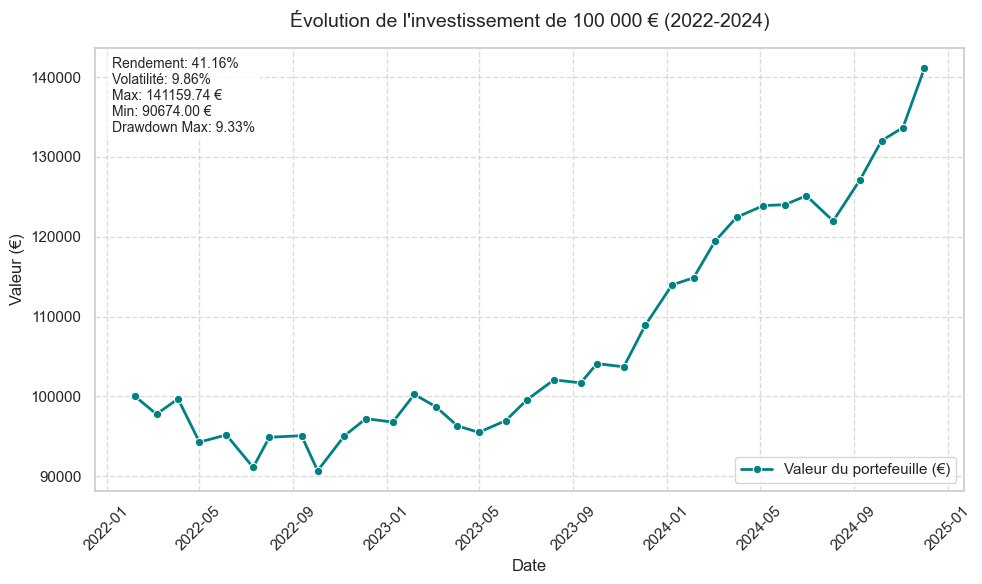

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Appliquer un style plus esthétique
# On utilise seaborn pour avoir un rendu graphique plus moderne avec une grille et des couleurs sobres
sns.set(style="whitegrid", palette="muted")
# On ajuste la taille de la figure et la taille de la police pour que ce soit bien lisible
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


# Identifier dynamiquement tous les tickers à partir des colonnes
# On extrait les tickers en prenant la partie avant le '_' pour toutes les colonnes qui finissent par '_weight'
# Ça nous permet de gérer automatiquement les 1500 tickers sans avoir à les lister à la main
tickers = [col.split('_')[0] for col in df.columns if col.endswith('_weight')]
# On affiche le nombre de tickers détectés pour vérifier qu'on a bien tout capturé
print(f"Nombre de tickers détectés : {len(tickers)}")  # Pour vérification

# Paramètres
# On définit l'investissement initial à 100 000 €, c'est notre capital de départ
initial_investment = 100000  # 100 000 €

# Initialisation
# On crée un dictionnaire pour chaque ticker, avec une quantité et une valeur initiales à 0
portfolio = {ticker: {'quantity': 0, 'value': 0} for ticker in tickers}
# On initialise notre trésorerie (cash) avec l'investissement initial
cash = initial_investment
# Liste pour stocker les valeurs du portefeuille à chaque date
portfolio_value = []
# On prend toutes les dates de l'index du DataFrame, ici de 2022-02-07 à 2024-12-02
dates = df.index

# Simulation
# On boucle sur chaque date pour simuler l'évolution du portefeuille
for date in dates:
    # On calcule la somme des poids non nuls à cette date pour normaliser l'allocation
    total_weight = sum(df[f'{ticker}_weight'][date] for ticker in tickers if df[f'{ticker}_weight'][date] > 0)
    
    # On met à jour le portefeuille si on a des poids non nuls
    if total_weight > 0:
        for ticker in tickers:
            # On récupère le poids et le prix pour le ticker à la date donnée
            weight = df[f'{ticker}_weight'][date]
            price = df[f'{ticker}_price'][date]
            if weight > 0 and price > 0:
                # Si le poids est positif et le prix valide, on achète proportionnellement au poids
                available_cash = cash * (weight / total_weight)
                # On calcule combien d'unités on peut acheter avec cet argent
                quantity = available_cash / price
                # On met à jour la quantité et la valeur dans le portefeuille
                portfolio[ticker]['quantity'] += quantity
                portfolio[ticker]['value'] = portfolio[ticker]['quantity'] * price
                # On déduit cet achat de la trésorerie
                cash -= available_cash
            elif weight == 0 and portfolio[ticker]['quantity'] > 0:
                # Si le poids devient 0 et qu'on détient des unités, on vend tout
                cash += portfolio[ticker]['quantity'] * price
                portfolio[ticker]['quantity'] = 0
                portfolio[ticker]['value'] = 0
    
    # On calcule la valeur totale du portefeuille (cash + valeur des actifs détenus)
    current_value = cash + sum(portfolio[ticker]['value'] for ticker in tickers)
    # On ajoute cette valeur à la liste
    portfolio_value.append(current_value)

# Calcul des métriques
# On crée une fonction pour calculer les métriques comme le rendement, la volatilité, etc.
def calculate_metrics(portfolio_value, dates):
    # On ajoute une date fictive (1 jour avant la première date) pour inclure l'investissement initial
    first_date = dates[0]
    plot_dates = [first_date - pd.Timedelta(days=1)] + list(dates)
    plot_values = [initial_investment] + list(portfolio_value)

    # On crée une série pandas pour faciliter les calculs de rendements
    portfolio_series = pd.Series(plot_values, index=plot_dates)
    # On calcule les rendements mensuels en pourcentage (variation relative)
    returns = portfolio_series.pct_change().dropna()

    # Rendement total : (valeur finale - valeur initiale) / valeur initiale * 100
    final_value = portfolio_value[-1]
    total_return = (final_value - initial_investment) / initial_investment * 100

    # Volatilité annualisée : on prend l'écart-type des rendements et on annualise avec √12 (car données mensuelles)
    volatility = returns.std() * np.sqrt(12) * 100

    # On trouve la valeur max et min du portefeuille sur toute la période
    max_value = max(portfolio_series)
    min_value = min(portfolio_series)

    # Drawdown max : on calcule la perte maximale par rapport au pic le plus haut
    running_max = np.maximum.accumulate(portfolio_series)
    drawdowns = (running_max - portfolio_series) / running_max * 100
    max_drawdown = drawdowns.max()

    return total_return, volatility, max_value, min_value, max_drawdown, plot_dates, plot_values

# On calcule les métriques pour la période totale
total_return, volatility, max_value, min_value, max_drawdown, plot_dates, plot_values = calculate_metrics(portfolio_value, dates)

# Graphique
# On crée une figure pour le graphique
plt.figure(figsize=(10, 6))
# On trace la courbe avec seaborn pour un rendu plus esthétique, avec des points pour chaque date
sns.lineplot(x=plot_dates, y=plot_values, label='Valeur du portefeuille (€)', marker='o', linewidth=2, color='teal')
# On ajoute un titre clair et des étiquettes pour les axes
plt.title('Évolution de l\'investissement de 100 000 € (2022-2024)', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Valeur (€)', fontsize=12)
# On ajoute une grille pour faciliter la lecture
plt.grid(True, linestyle='--', alpha=0.7)
# On affiche la légende
plt.legend()
# On rotate les dates pour éviter qu'elles se chevauchent
plt.xticks(rotation=45)

# On ajoute les métriques directement sur le graphique dans une boîte
metrics_text = (
    f'Rendement: {total_return:.2f}%\n'
    f'Volatilité: {volatility:.2f}%\n'
    f'Max: {max_value:.2f} €\n'
    f'Min: {min_value:.2f} €\n'
    f'Drawdown Max: {max_drawdown:.2f}%'
)
plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# On ajuste la mise en page pour éviter les chevauchements
plt.tight_layout()
# On sauvegarde le graphique dans un fichier
plt.savefig('portfolio_evolution_total_period.png')